In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers.core import Dense,Activation,Dropout
from keras.layers import LSTM
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn import svm
from nltk.corpus import stopwords 
from nltk.tokenize import word_tokenize 
from xgboost import XGBClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score
from sklearn.tree import DecisionTreeClassifier
from keras.callbacks import EarlyStopping
import math
import os
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.metrics.pairwise import linear_kernel, cosine_similarity
from nltk.stem.snowball import SnowballStemmer
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.corpus import wordnet
from nltk.stem import WordNetLemmatizer


Using TensorFlow backend.


In [2]:
hotel_details=pd.read_csv('../input/hotel-recommendation/Hotel_details.csv',delimiter=',')
hotel_rooms=pd.read_csv('../input/hotel-recommendation/Hotel_Room_attributes.csv',delimiter=',')
hotel_cost=pd.read_csv('../input/hotel-recommendation/hotels_RoomPrice.csv',delimiter=',')

In [3]:
hotel_details.head()

,id,hotelid,hotelname,address,city,country,zipcode,propertytype,starrating,latitude,longitude,Source,url,curr
0,46406,1771651,Mediteran Bungalow Galeb,Vukovarska 7,Omis,Croatia,21310.0,Holiday parks,4,43.440124,16.682505,2,https://www.booking.com/hotel/hr/bungalow-luxu...,EUR
1,46407,177167,Hotel Polonia,Plac Teatralny 5,Torun,Poland,NaN,Hotels,3,53.012329,18.603800,5,https://www.agoda.com/en-gb/hotel-polonia/hote...,EUR
2,46408,1771675,Rifugio Sass Bece,"Belvedere del Pordoi,1",Canazei,Italy,38032.0,Hotels,3,46.477920,11.813350,2,http://www.booking.com/hotel/it/rifugio-sass-b...,EUR
3,46409,177168,Madalena Hotel,Mykonos,Mykonos,Greece,84600.0,Hotels,3,37.452316,25.329849,5,https://www.agoda.com/en-gb/madalena-hotel/hot...,EUR
4,46410,1771718,Pension Morenfeld,Mair im Korn Strasse 2,Lagundo,Italy,39022.0,Hotels,3,46.682780,11.131736,2,http://www.booking.com/hotel/it/pension-morenf...,EUR


In [4]:
hotel_rooms.head()

,id,hotelcode,roomamenities,roomtype,ratedescription
0,50677497,634876,Air conditioning: ;Alarm clock: ;Carpeting: ;C...,Double Room,"Room size: 15 m²/161 ft², Shower, 1 king bed"
1,50672149,8328096,Air conditioning: ;Closet: ;Fireplace: ;Free W...,Vacation Home,"Shower, Kitchenette, 2 bedrooms, 1 double bed ..."
2,50643430,8323442,Air conditioning: ;Closet: ;Dishwasher: ;Firep...,Vacation Home,"Shower, Kitchenette, 2 bedrooms, 1 double bed ..."
3,50650317,7975,Air conditioning: ;Clothes rack: ;Coffee/tea m...,Standard Triple Room,"Room size: 20 m²/215 ft², Shower, 3 single beds"
4,50650318,7975,Air conditioning: ;Clothes rack: ;Coffee/tea m...,Standard Triple Room,"Room size: 20 m²/215 ft², Shower, 3 single beds"


# Data Cleaning and transformations

In [5]:
del hotel_details['id']
del hotel_rooms['id']
del hotel_details['zipcode']

In [6]:
hotel_details=hotel_details.dropna()
hotel_rooms=hotel_rooms.dropna()

In [7]:
hotel_details.drop_duplicates(subset='hotelid',keep=False,inplace=True)
hotel=pd.merge(hotel_rooms,hotel_details,left_on='hotelcode',right_on='hotelid',how='inner')

In [8]:
hotel.columns

Index(['hotelcode', 'roomamenities', 'roomtype', 'ratedescription', 'hotelid',
       'hotelname', 'address', 'city', 'country', 'propertytype', 'starrating',
       'latitude', 'longitude', 'Source', 'url', 'curr'],
      dtype='object')

In [9]:
del hotel['hotelid']
del hotel['url']
del hotel['curr']
del hotel['Source']

In [10]:
hotel.columns

Index(['hotelcode', 'roomamenities', 'roomtype', 'ratedescription',
       'hotelname', 'address', 'city', 'country', 'propertytype', 'starrating',
       'latitude', 'longitude'],
      dtype='object')

In [11]:
data_types = hotel.dtypes
data_types

hotelcode            int64
roomamenities       object
roomtype            object
ratedescription     object
hotelname           object
address             object
city                object
country             object
propertytype        object
starrating           int64
latitude           float64
longitude          float64
dtype: object

In [12]:
null_counts = hotel.isnull().sum()
null_counts

hotelcode          0
roomamenities      0
roomtype           0
ratedescription    0
hotelname          0
address            0
city               0
country            0
propertytype       0
starrating         0
latitude           0
longitude          0
dtype: int64

In [13]:
hotel.head()

,hotelcode,roomamenities,roomtype,ratedescription,hotelname,address,city,country,propertytype,starrating,latitude,longitude
0,634876,Air conditioning: ;Alarm clock: ;Carpeting: ;C...,Double Room,"Room size: 15 m²/161 ft², Shower, 1 king bed",The Old Cider House,25 Castle Street,Nether Stowey,United Kingdom,Hotels,4,51.150921,-3.15847
1,634876,Air conditioning: ;Alarm clock: ;Carpeting: ;C...,Double Room,"Room size: 15 m²/161 ft², Shower, 1 king bed",The Old Cider House,25 Castle Street,Nether Stowey,United Kingdom,Hotels,4,51.150921,-3.15847
2,634876,Air conditioning: ;Alarm clock: ;Carpeting: ;C...,Deluxe Double Room with Shower,"Room size: 17 m²/183 ft², Shower, 1 queen bed ...",The Old Cider House,25 Castle Street,Nether Stowey,United Kingdom,Hotels,4,51.150921,-3.15847
3,634876,Air conditioning: ;Alarm clock: ;Carpeting: ;C...,Superior Double Room,"Room size: 17 m²/183 ft², Shower, 1 double bed",The Old Cider House,25 Castle Street,Nether Stowey,United Kingdom,Hotels,4,51.150921,-3.15847
4,634876,Air conditioning: ;Alarm clock: ;Carpeting: ;C...,Standard Double or Twin Room,"Room size: 13 m²/140 ft², Shower, 1 queen bed ...",The Old Cider House,25 Castle Street,Nether Stowey,United Kingdom,Hotels,4,51.150921,-3.15847


# Data Visualization

In [14]:
star_ratings_count = hotel['starrating'].value_counts().sort_index()


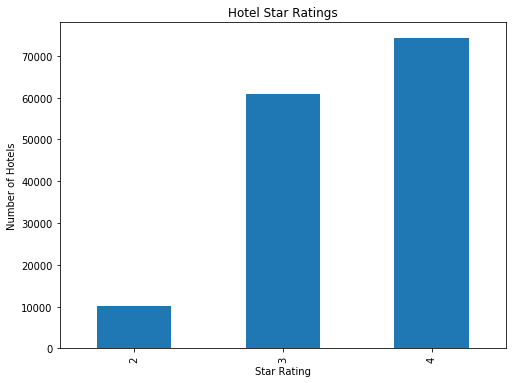

In [15]:
plt.figure(figsize=(8, 6))
star_ratings_count.plot(kind='bar')
plt.title('Hotel Star Ratings')
plt.xlabel('Star Rating')
plt.ylabel('Number of Hotels')
plt.show()

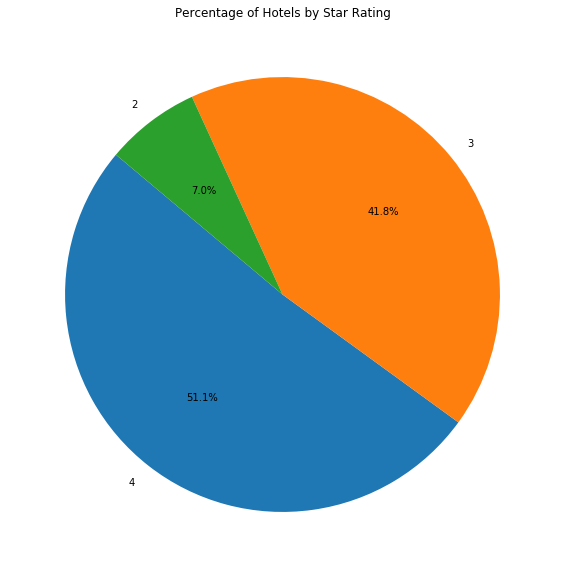

In [16]:
star_rating_counts = hotel['starrating'].value_counts()

# Create a pie chart
plt.figure(figsize=(10, 10))
plt.pie(star_rating_counts, labels=star_rating_counts.index, autopct='%1.1f%%', startangle=140)
plt.title('Percentage of Hotels by Star Rating')
plt.show()

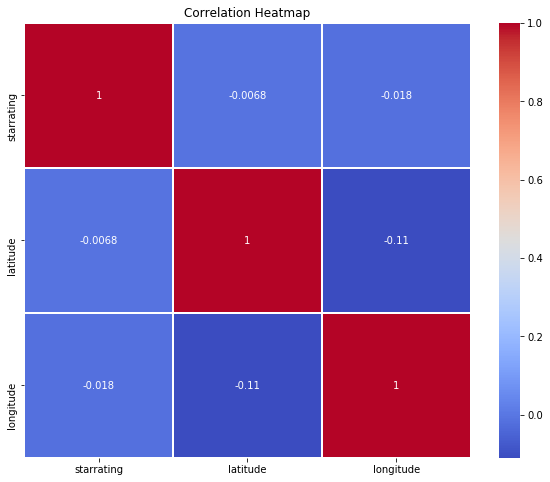

In [17]:
numerical_columns = hotel.select_dtypes(include=['int64', 'float64']).drop(columns=['hotelcode'])

# Create a correlation matrix
correlation_matrix = numerical_columns.corr()

# Create a heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', linewidths=0.5)
plt.title('Correlation Heatmap')
plt.show()

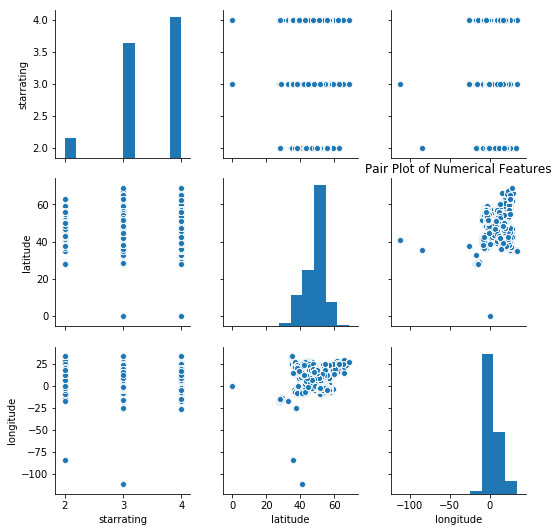

In [18]:
sns.pairplot(hotel[['starrating', 'latitude', 'longitude',]])
plt.title('Pair Plot of Numerical Features')
plt.show()

# Recommender system based only on City and ratings about the hotel

In [19]:
def citybased(city):
    hotel['city']=hotel['city'].str.lower()
    citybase=hotel[hotel['city']==city.lower()]
    citybase=citybase.sort_values(by='starrating',ascending=False)
    citybase.drop_duplicates(subset='hotelcode',keep='first',inplace=True)
    if(citybase.empty==0):
        hname=citybase[['hotelname','starrating','address','roomamenities','ratedescription']]
        return hname.head()
    else:
        print('No Hotels Available')

In [20]:
print('Top 5 hotels')
citybased('London')

Top 5 hotels


,hotelname,starrating,address,roomamenities,ratedescription
48985,The Colonnade London Hotel,4,2 Warrington Crescent,Additional toilet: ;Air conditioning: ;Alarm c...,"Room size: 28 m²/301 ft², Balcony/terrace, Non..."
58663,South Point Suites - London Bridge,4,Bermondsey Street,Air conditioning: ;Alarm clock: ;Blackout curt...,"Room size: 24 m²/258 ft², Street view, Non-smo..."
106943,Doubletree by Hilton London Chelsea,4,Imperial Road Imperial Wharf,Air conditioning: ;Alarm clock: ;Blackout curt...,"Room size: 20 m²/215 ft², Street view, Non-smo..."
57452,Sir Christopher Wren Hotel & Spa,4,Unknown,Air conditioning: ;Alarm clock: ;Bathrobes: ;B...,"Room size: 25 m²/269 ft², Non-smoking, Shower ..."
92479,The Manor Hotel Heathrow,4,"Village Green, Datchet,",Additional bathroom: ;Additional toilet: ;Air ...,"Shower and bathtub, 1 double bed"


In [21]:
room_no=[
     ('king',2),
   ('queen',2), 
    ('triple',3),
    ('master',3),
   ('family',4),
   ('murphy',2),
   ('quad',4),
   ('double-double',4),
   ('mini',2),
   ('studio',1),
    ('junior',2),
   ('apartment',4),
    ('double',2),
   ('twin',2),
   ('double-twin',4),
   ('single',1),
     ('diabled',1),
   ('accessible',1),
    ('suite',2),
    ('one',2)
   ]

In [22]:
def calc():
    guests_no=[]
    for i in range(hotel.shape[0]):
        temp=hotel['roomtype'][i].lower().split()
        flag=0
        for j in range(len(temp)):
            for k in range(len(room_no)):
                if temp[j]==room_no[k][0]:
                    guests_no.append(room_no[k][1])
                    flag=1
                    break
            if flag==1:
                break
        if flag==0:
            guests_no.append(2)
    hotel['guests_no']=guests_no

calc()

In [23]:
hotel['roomamenities']=hotel['roomamenities'].str.replace(': ;',',')

In [24]:
def requirementbased(city,number,features):
    hotel['city']=hotel['city'].str.lower()
    hotel['roomamenities']=hotel['roomamenities'].str.lower()
    features=features.lower()
    features_tokens=word_tokenize(features)  
    sw = stopwords.words('english')
    lemm = WordNetLemmatizer()
    f1_set = {w for w in features_tokens if not w in sw}
    f_set=set()
    for se in f1_set:
        f_set.add(lemm.lemmatize(se))
    reqbased=hotel[hotel['city']==city.lower()]
    reqbased=reqbased[reqbased['guests_no']==number]
    reqbased=reqbased.set_index(np.arange(reqbased.shape[0]))
    l1 =[];l2 =[];cos=[];
    for i in range(reqbased.shape[0]):
        temp_tokens=word_tokenize(reqbased['roomamenities'][i])
        temp1_set={w for w in temp_tokens if not w in sw}
        temp_set=set()
        for se in temp1_set:
            temp_set.add(lemm.lemmatize(se))
        rvector = temp_set.intersection(f_set)
        #print(rvector)
        cos.append(len(rvector))
    reqbased['similarity']=cos
    reqbased=reqbased.sort_values(by='similarity',ascending=False)
    reqbased.drop_duplicates(subset='hotelcode',keep='first',inplace=True)
    return reqbased[['city','hotelname','roomtype','guests_no','starrating','address','roomamenities','ratedescription','similarity']].head(10)

In [25]:
requirementbased('London',4,'I need air conditioned room. I should have an alarm clock.')

,city,hotelname,roomtype,guests_no,starrating,address,roomamenities,ratedescription,similarity
0,london,Holiday Inn London - Heathrow T5,Family Room,4,4,Old Bath Road,"air conditioning,alarm clock,blackout curtains...","Room size: 25 m²/269 ft², Non-smoking, Separat...",4
281,london,Courtyard Luton Airport,"Superior Family Room, Guest room, 1 King, Sofa...",4,4,Airport Way,"additional toilet,air conditioning,alarm clock...","Shower, 1 king bed and 1 sofa bed",4
292,london,The Colonnade London Hotel,Three-Bedroom Luxury Apartment,4,4,2 Warrington Crescent,"additional bathroom,additional toilet,air cond...","Room size: 121 m²/1302 ft², 2 bathrooms, Showe...",4
722,london,Sheraton Heathrow Hotel,"Family Room 1Twin, Guest room, 1 Queen",4,4,Heathrow Airport,"air conditioning,alarm clock,bathrobes,closet,...","Shower, 1 king bed",4
270,london,Best Western Palm Hotel,Family Room with 1 Double Bed and 1 Single Bed...,4,3,64-76 Hendon Way,"additional toilet,air conditioning,alarm clock...","Room size: 26 m²/280 ft², Non-smoking, Shower,...",4
246,london,Best Western Burns Hotel London,Family Room,4,3,18-26 Barkston Gardens,"air conditioning,alarm clock,carpeting,closet,...","Room size: 20 m²/215 ft², Separate shower/bath...",4
294,london,Princess Hotel,Basic Family Room with Shared Bathroom,4,2,35-39 Argyle Street,"air conditioning,alarm clock,carpeting,closet,...","Room size: 20 m²/215 ft², Non-smoking, Shared ...",4
313,london,Comfort Inn St Pancras - Kings Cross,Family,4,3,2-5 St. Chad's Street,"air conditioning,alarm clock,coffee/tea maker,...","Room size: 20 m²/215 ft², Non-smoking, Shower,...",4
799,london,Sheraton Skyline Hotel London Heathrow,"Family Room, Guest room, 2 Double",4,4,"Heathrow Airport, Bath Road","air conditioning,alarm clock,bathrobes,carpeti...","Non-smoking, Shower and bathtub, 2 double beds",4
775,london,Barrington Lodge,Deluxe Family Suite,4,4,Hunter Road,"air conditioning,alarm clock,carpeting,closet,...","Room size: 30 m²/323 ft², Shower, 1 king bed a...",4


Rate Description Based

In [26]:
def ratebased(city,number,features):
    hotel['city']=hotel['city'].str.lower()
    hotel['ratedescription']=hotel['ratedescription'].str.lower()
    features=features.lower()
    features_tokens=word_tokenize(features)  
    sw = stopwords.words('english')
    lemm = WordNetLemmatizer()
    f1_set = {w for w in features_tokens if not w in sw}
    f_set=set()
    for se in f1_set:
        f_set.add(lemm.lemmatize(se))
    rtbased=hotel[hotel['city']==city.lower()]
    rtbased=rtbased[rtbased['guests_no']==number]
    rtbased=rtbased.set_index(np.arange(rtbased.shape[0]))
    l1 =[];l2 =[];cos=[];
    
    for i in range(rtbased.shape[0]):
        temp_tokens=word_tokenize(rtbased['ratedescription'][i])
        temp1_set={w for w in temp_tokens if not w in sw}
        temp_set=set()
        for se in temp1_set:
            temp_set.add(lemm.lemmatize(se))
        rvector = temp_set.intersection(f_set)
        
        cos.append(len(rvector))
    rtbased['similarity']=cos
    rtbased=rtbased.sort_values(by='similarity',ascending=False)
    rtbased.drop_duplicates(subset='hotelcode',keep='first',inplace=True)
    return rtbased[['city','hotelname','roomtype','guests_no','starrating','address','ratedescription','similarity']].head(10)

In [27]:
ratebased('London',4,'I need free wifi.')

,city,hotelname,roomtype,guests_no,starrating,address,ratedescription,similarity
710,london,Grantly Hotel,Standard Quad Room,4,3,50 Shepherds Bush Green,"free wi-fi, extra low price! (non-refundable),...",2
454,london,The Heathrow Inn Hotel,Family Room 5 people,4,3,140 Coldharbour Lane,"free wi-fi, extra low price! (non-refundable)",1
696,london,Radisson Blu Edwardian Kenilworth - Bloomsbury,Standard Family,4,4,97 Great Russell Street,"free wi-fi, cancellation policy",1
423,london,The Park City Grand Plaza Kensington Hotel,Family Room - Room Only,4,4,18-30 Lexham Gardens,"free wi-fi, extra low price! (non-refundable)",1
273,london,Best Western Palm Hotel,Family room Standard,4,3,64-76 Hendon Way,"pay nothing until december 27, 2019, free wi-f...",1
408,london,Ramada by Wyndham London Stansted Airport,Family Room,4,3,"Birchanger Green Services, M11, Junction 8,Old...","free wi-fi, extra low price! (non-refundable)",1
849,london,The Bridge Hotel Chertsey,Family Double Room,4,3,"Bridge Road, Chertsey","pay at the hotel, free wi-fi, free cancellatio...",1
572,london,Dolphin Hotel,Family Room Capacity 5,4,2,32-34 Norfolk Square,"free breakfast, pay nothing until december 26,...",1
521,london,The Thistle Bloomsbury Park Hotel,Family Room Standard,4,4,126 Southampton Row,"free wi-fi, cancellation policy",1
807,london,The Cleveland Hotel,Family Studio,4,4,39-40 Cleveland Square,"free wi-fi, extra low price! (non-refundable)",1
